# NUTS vs. Metropolis on a Bimodal Target in PyMC

This notebook builds a **bimodal 2D Gaussian mixture** as the target distribution using a `pm.Potential`,
then samples it with **NUTS** and **Random-Walk Metropolis** to contrast behavior on multimodality.

**What you'll see:**
- NUTS efficiently explores *within* a mode but tends to stay trapped there.
- Metropolis explores poorly within a mode but can *occasionally hop* across the low-density gap.

⚠️ If PyMC or ArviZ are missing, run the first cell to install them.

In [1]:
try:
    import pymc as pm
    import pytensor.tensor as pt
    import arviz as az
except Exception as e:
    import sys
    !{sys.executable} -m pip install -q pymc arviz
    import pymc as pm
    import pytensor.tensor as pt
    import arviz as az

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from math import pi
np.random.seed(42)
print('PyMC', pm.__version__)

PyMC 5.16.2


## Define the bimodal target via `pm.Potential`

We create a 50/50 mixture of two 2D Gaussians centered at (-3,0) and (3,0) with the same covariance. To make the
variable `x` follow this target, we give it a convenient Gaussian prior and then add a `Potential` term equal to:

\begin{equation}
 \log p_\text{mixture}(x) - \log p_\text{prior}(x),
\end{equation}

so the resulting posterior is proportional to the mixture density. This keeps gradients well-defined for NUTS.

In [2]:
mu1 = np.array([-3.0, 0.0])
mu2 = np.array([ 3.0, 0.0])
Sigma = np.array([[0.3, 0.0], [0.0, 0.3]])
Sigma_inv = inv(Sigma)
logdet_Sigma = np.log(np.linalg.det(Sigma))
dim = 2

def mvn_logpdf_tensor(x, mu, Sigma_inv, logdet_Sigma):
    dx = x - mu
    quad = pt.dot(dx, pt.dot(Sigma_inv, dx))
    return -0.5 * (dim * np.log(2*np.pi) + logdet_Sigma + quad)

def mixture_logp_tensor(x):
    l1 = mvn_logpdf_tensor(x, mu1, Sigma_inv, logdet_Sigma)
    l2 = mvn_logpdf_tensor(x, mu2, Sigma_inv, logdet_Sigma)
    m = pt.maximum(l1, l2)
    return pt.log(0.5*pt.exp(l1-m) + 0.5*pt.exp(l2-m)) + m

with pm.Model() as model:
    # convenient Gaussian prior for well-behaved gradients
    prior_mu = np.zeros(2)
    prior_cov = np.eye(2)
    x = pm.MvNormal('x', mu=prior_mu, cov=prior_cov, shape=2)
    # Replace prior with mixture via Potential correction
    logp_prior = mvn_logpdf_tensor(x, prior_mu, np.eye(2), 0.0)  # log|I|=0
    logp_mix   = mixture_logp_tensor(x)
    pm.Potential('target_logp', logp_mix - logp_prior)

## Sample with NUTS (PyMC's HMC variant)

In [18]:
with model:
    idata_nuts = pm.sample(draws=8000, tune=1000, chains=1, random_seed=42, step=pm.NUTS(target_accept=0.8))

posterior_nuts = idata_nuts.posterior['x'].stack(sample=("chain","draw")).values.T  # shape (n,2)
posterior_nuts[:5]

Sequential sampling (1 chains in 1 job)
NUTS: [x]


Output()

Sampling 1 chain for 1_000 tune and 8_000 draw iterations (1_000 + 8_000 draws total) took 11 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[-1.55621043,  0.3494736 ],
       [-3.49577726,  0.54579037],
       [-2.99134201,  0.06175777],
       [-2.63337644, -0.1216601 ],
       [-2.63337644, -0.1216601 ]])

## Sample with Random-Walk Metropolis

In [15]:
with model:
    # Proposal std tuned to allow occasional big jumps. Adjust if you see 0 or 100% acceptance.
    step_rwmh = pm.Metropolis()
    idata_mh = pm.sample(draws=8000, tune=1000, chains=1, random_seed=123, step=step_rwmh)

posterior_mh = idata_mh.posterior['x'].stack(sample=("chain","draw")).values.T  # shape (n,2)
posterior_mh[:5]

Sequential sampling (1 chains in 1 job)
Metropolis: [x]


Output()

Sampling 1 chain for 1_000 tune and 8_000 draw iterations (1_000 + 8_000 draws total) took 5 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[-3.04982682,  0.30954312],
       [-3.44978115,  0.30954312],
       [-3.38501426, -0.47697829],
       [-3.38501426, -0.47697829],
       [-3.38501426, -0.03795775]])

## Helper functions: contour, trace, and mode switches

In [19]:
def mixture_pdf_np(points):
    # points: (N,2)
    def mvn_pdf(x, mu, Sigma):
        dx = x - mu
        expo = -0.5 * np.einsum('...i,ij,...j->...', dx, Sigma_inv, dx)
        norm = (2*np.pi)**(-dim/2) * np.exp(-0.5*logdet_Sigma)
        return norm * np.exp(expo)
    return 0.5*mvn_pdf(points, mu1, Sigma) + 0.5*mvn_pdf(points, mu2, Sigma)

def plot_contour(ax=None):
    if ax is None:
        ax = plt.gca()
    gx = np.linspace(-7,7,200)
    gy = np.linspace(-5,5,200)
    XX, YY = np.meshgrid(gx, gy)
    XY = np.stack([XX.ravel(), YY.ravel()], axis=1)
    Z = mixture_pdf_np(XY).reshape(XX.shape)
    cs = ax.contour(XX, YY, Z, levels=15)
    return ax

def count_switches(samples):
    # samples: (N,2). We'll use x>0 as being in the right mode.
    signs = (samples[:,0] > 0).astype(int)
    return np.count_nonzero(np.diff(signs))

def try_accept_rate(idata):
    try:
        # NUTS often has 'mean_tree_accept'; Metropolis may have 'accept'
        st = idata.sample_stats
        if 'mean_tree_accept' in st:
            return float(np.asarray(st['mean_tree_accept']).mean())
        if 'acceptance_rate' in st:
            return float(np.asarray(st['acceptance_rate']).mean())
        if 'accepted' in st:  # boolean per draw
            acc = np.asarray(st['accepted']).astype(float)
            return float(acc.mean())
    except Exception:
        pass
    return None

## Plots

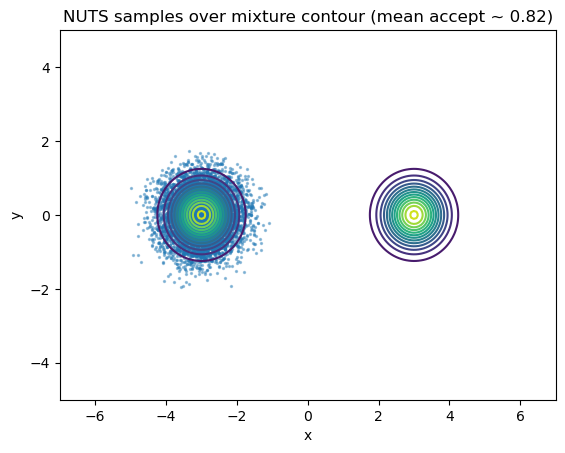

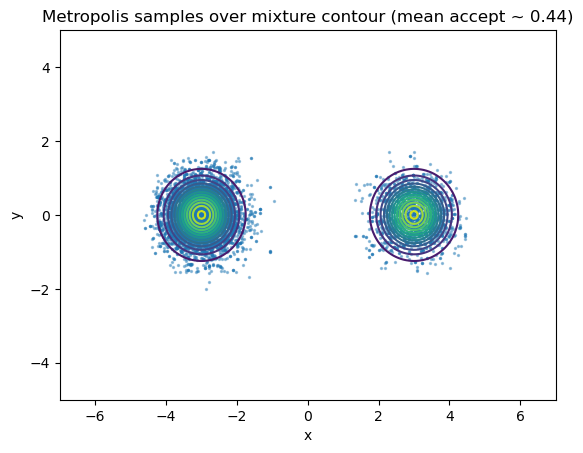

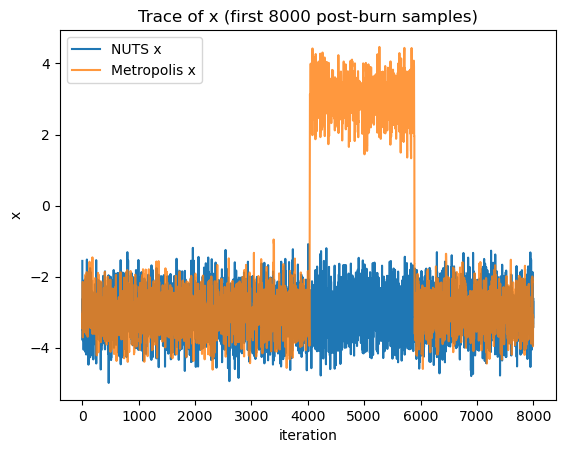

Mode switches (x<0 vs x>0 proxy):
  NUTS       : 0
  Metropolis : 2


In [20]:
# HMC/NUTS scatter over contour
plt.figure()
ax = plot_contour()
ax.scatter(posterior_nuts[:,0], posterior_nuts[:,1], s=2, alpha=0.4)
ar = try_accept_rate(idata_nuts)
title = 'NUTS samples over mixture contour'
if ar is not None:
    title += f' (mean accept ~ {ar:.2f})'
ax.set_title(title)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

# Metropolis scatter over contour
plt.figure()
ax = plot_contour()
ax.scatter(posterior_mh[:,0], posterior_mh[:,1], s=2, alpha=0.4)
ar = try_accept_rate(idata_mh)
title = 'Metropolis samples over mixture contour'
if ar is not None:
    title += f' (mean accept ~ {ar:.2f})'
ax.set_title(title)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

# Trace comparison (x-dimension)
N = max(len(posterior_nuts), len(posterior_mh))
plt.figure()
plt.plot(posterior_nuts[:N,0], label='NUTS x')
plt.plot(posterior_mh[:N,0], label='Metropolis x', alpha=0.8)
plt.title(f'Trace of x (first {N} post-burn samples)')
plt.xlabel('iteration')
plt.ylabel('x')
plt.legend()
plt.show()

print('Mode switches (x<0 vs x>0 proxy):')
print('  NUTS       :', count_switches(posterior_nuts))
print('  Metropolis :', count_switches(posterior_mh))

## Notes & Tips
- If NUTS never switches modes (common), that’s expected. Increase warmup or change random seed; it usually won’t help much.
- To genuinely explore both modes robustly, try **Parallel Tempering / Replica Exchange** (not in this minimal notebook).
- You can also try changing the mixture gap by moving the means closer/farther or increasing covariance.